# **PROJET FINAL DE MACHINE LEARNING**

**Membres de l'équipe:**


*   BRUNACHE Daril
*   GABRIEL Jefferson

*   LAROSE Christ-Yan Love

*   TEROGENE Spencer





**Description du projet**

Ce projet consiste à identifier deux des maladies cutanées les plus populaires en l'occurence: l'acne et la melanoma. Etant donné qu'il n'existe pas encore de dataset concret regroupant assez de photos dans le domaine de dermatologie, nous avons utilisé le web scraping pour télécharger des images complémentaires.
A noter que ce model n'est pas une substitution à un dermatologue, il nous manque encore de photos pour toute précision médicale.

# ========================================================================



### Telechargement des photos pour la construction du dataset

In [ ]:
#importation of the required libraries for the web scraping and to download the pictures
import requests
import os
from tqdm import tqdm
from bs4 import BeautifulSoup as bs
from urllib.parse import urljoin, urlparse

In [ ]:
def is_valid(url):
    """
    Checks whether `url` is a valid URL.
    """
    parsed = urlparse(url)
    return bool(parsed.netloc) and bool(parsed.scheme)

In [ ]:
def get_all_images(url):
    """
    Returns all image URLs on a single `url`
    """
    soup = bs(requests.get(url).content, "html.parser")
    urls = []
    for img in tqdm(soup.find_all("img"), "Extracting images"):
        img_url = img.attrs.get("src")
        if not img_url:
            # if img does not contain src attribute, just skip
            continue
        # make the URL absolute by joining domain with the URL that is just extracted
        img_url = urljoin(url, img_url)
        try:
            pos = img_url.index("?")
            img_url = img_url[:pos]
        except ValueError:
            pass
        # finally, if the url is valid
        if is_valid(img_url):
            urls.append(img_url)
    return urls

In [ ]:
def download(url, pathname):
    """
    Downloads a file given an URL and puts it in the folder `pathname`
    """
    # if path doesn't exist, make that path dir
    if not os.path.isdir(pathname):
        os.makedirs(pathname)
    # download the body of response by chunk, not immediately
    response = requests.get(url, stream=True)
    # get the total file size
    file_size = int(response.headers.get("Content-Length", 0))
    # get the file name
    filename = os.path.join(pathname, url.split("/")[-1])
    # progress bar, changing the unit to bytes instead of iteration (default by tqdm)
    progress = tqdm(response.iter_content(1024), f"Downloading {filename}", total=file_size, unit="B", unit_scale=True, unit_divisor=1024)
    with open(filename, "wb") as f:
        for data in progress.iterable:
            # write data read to the file
            f.write(data)
            # update the progress bar manually
            progress.update(len(data))

In [ ]:
def main(url, path):
    # get all images
    imgs = get_all_images(url)
    for img in imgs:
        # for each image, download it
        download(img, path)

In [ ]:
main("https://dermnetnz.org/topics/acne-affecting-the-back-images?stage=Live", "data//acne")
main("https://dermnetnz.org/topics/acne-face-images?stage=Live", "data//acne")
main("https://dermnetnz.org/topics/actinic-keratosis-face-images?stage=Live", "data//actinic")
main("https://dermnetnz.org/topics/actinic-keratosis-affecting-the-hand-images?stage=Live", "data//actinic")
main("https://dermnetnz.org/topics/actinic-keratosis-scalp-images?stage=Live", "data//actinic")
main("https://dermnetnz.org/topics/actinic-keratosis-on-the-nose-images?stage=Live", "data//actinic")
main("https://A.org/topics/actinic-keratosis-imiquimod-images?stage=Live", "data//actinic")
main("https://dermnetnz.org/images/melanoma-in-situ-images?stage=Live", "data//melanoma")
main("https://dermnetnz.org/topics/mole-images?stage=Live", "data//melanoma")

main("https://skinsight.com/skin-conditions/acne-vulgaris/", "data//acne")
main("https://skinsight.com/skin-conditions/acne-vulgaris/teen/", "data//acne")
main("https://skinsight.com/skin-conditions/acne-vulgaris/child/", "data//acne")

for i in range(1, 51):
  main("https://www.shutterstock.com/search/acne?image_type=photo&page="+str(i), "data//acne")
  main("https://stock.adobe.com/au/search?filters%5Bcontent_type%3Aphoto%5D=1&filters%5Bcontent_type%3Aillustration%5D=0&filters%5Bcontent_type%3Azip_vector%5D=0&filters%5Bcontent_type%3Avideo%5D=0&filters%5Bcontent_type%3Atemplate%5D=0&filters%5Bcontent_type%3A3d%5D=0&filters%5Bcontent_type%3Aaudio%5D=0&filters%5Binclude_stock_enterprise%5D=0&filters%5Bis_editorial%5D=0&filters%5Bfree_collection%5D=0&filters%5Bcontent_type%3Aimage%5D=1&k=acne&order=relevance&safe_search=1&limit=100&search_type=filter-select&search_page="+str(i)+"&get_facets=1", "data//acne")
  main("https://www.shutterstock.com/search/melanoma?image_type=photo&people_number=1&page="+str(i), "data//melanoma")
  main("https://www.shutterstock.com/search/moles?image_type=photo&people_number=1&page="+str(i), "data//melanoma")




### Entrainement du model

In [27]:
#required importation for the learning
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import sklearn.model_selection as model_selection
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [34]:
# Location of the folders
DATADIR = "/kaggle/input/dermato/data"  
CATEGORIES = ["acne", "melanoma"]          

In [35]:
#convert picture into numpy arrays
IMG_SIZE = 180
training_data = []
for category in CATEGORIES:  
    path = os.path.join(DATADIR,category)  # create path each illness
    class_num = CATEGORIES.index(category)  # get the classification  
    for img in os.listdir(path):  # iterate over each image per illness
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our dataset                
            except Exception as e:  # in the interest in keeping the output clean...
                print(e)

OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



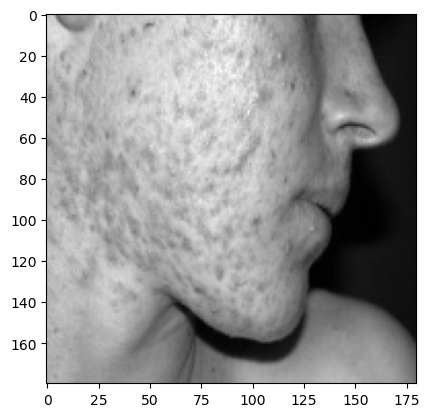

(1769, 180, 180, 1)
(180, 180, 1)


In [36]:
# Prepare features and labels for the training
X = []
y = []
for features,label in training_data:
    X.append(features)
    y.append(label)

plt.imshow(X[0], cmap='gray')  # graph it
plt.show() 

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)      # reformat the features
print(X.shape)
print(X[0].shape)

X = X.astype('float32')
X = X/255.0
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=5)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [37]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [38]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (180,180,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 2 , activation = 'softmax'))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
#Training of the model
epochs=100

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(datagen.flow(X_train,y_train, batch_size = 32) ,epochs = epochs , validation_data = datagen.flow(X_test, y_test) ,callbacks = [learning_rate_reduction])
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, shuffle=True)

Epoch 1/100


2023-03-06 20:46:08.536431: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


45/45 [==============================] - 8s 107ms/step - loss: 1.2444 - accuracy: 0.8014 - val_loss: 0.5226 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 5s 106ms/step - loss: 0.3498 - accuracy: 0.8375 - val_loss: 0.4723 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 0.3070 - accuracy: 0.8735
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
45/45 [==============================] - 5s 114ms/step - loss: 0.3070 - accuracy: 0.8735 - val_loss: 0.9215 - val_accuracy: 0.1808 - lr: 0.0010
Epoch 4/100
45/45 [==============================] - 5s 106ms/step - loss: 0.2474 - accuracy: 0.8982 - val_loss: 0.5784 - val_accuracy: 0.7797 - lr: 3.0000e-04
Epoch 5/100
45/45 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9131
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
45/45 [==============================] - 5s 102ms/step

In [40]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

12/12 [==============================] - 0s 11ms/step - loss: 0.1985 - accuracy: 0.9209
Loss of the model is -  0.19848550856113434
12/12 [==============================] - 0s 9ms/step - loss: 0.1985 - accuracy: 0.9209
Accuracy of the model is -  92.09039807319641 %


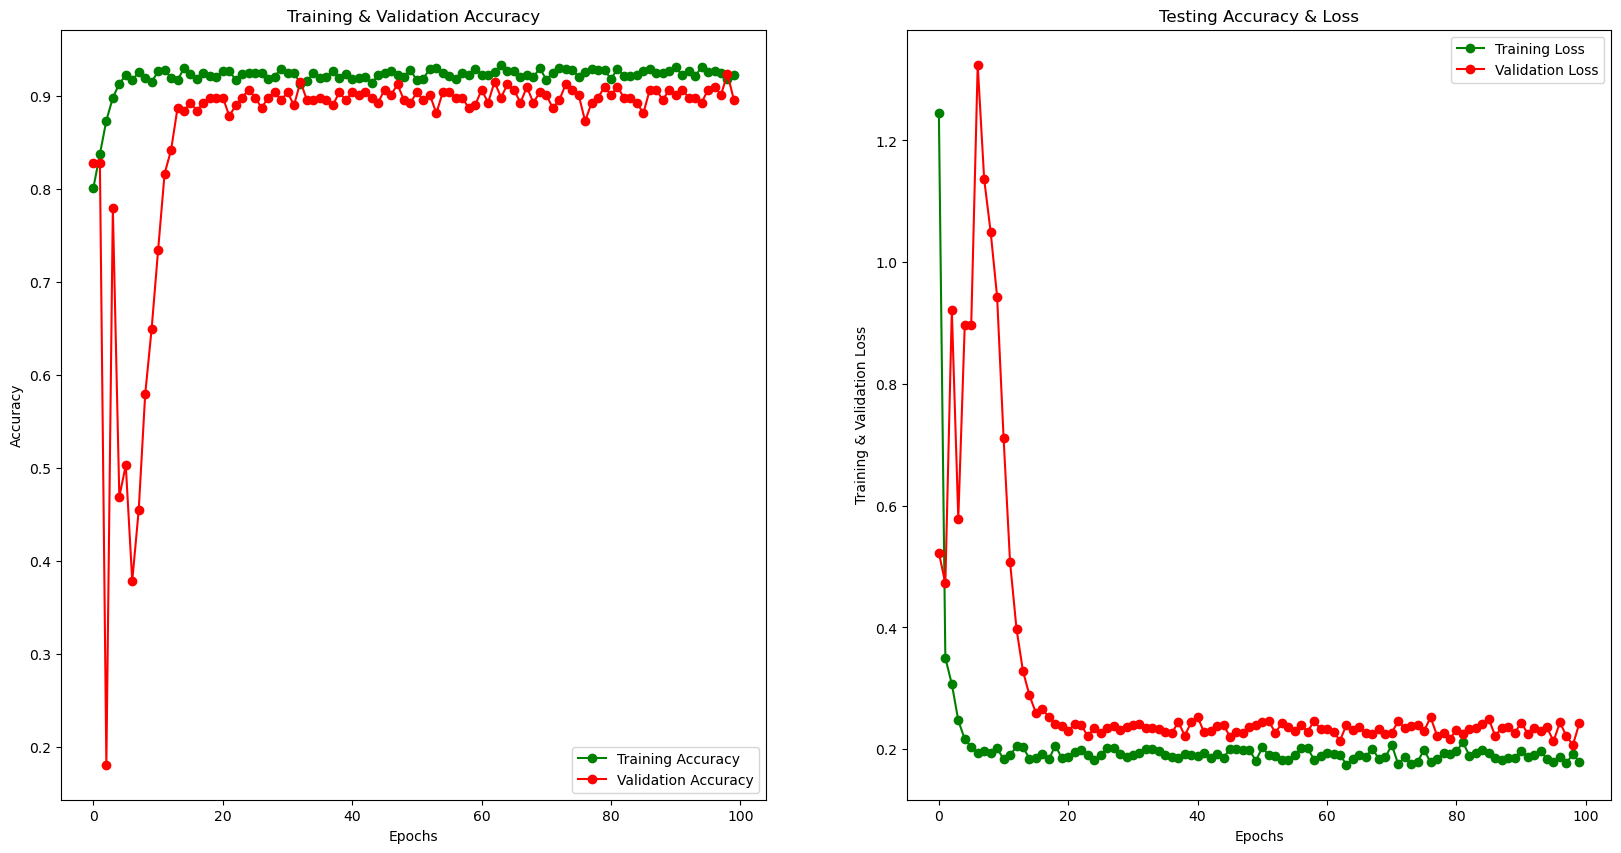

In [41]:
epochs = [i for i in range(epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [42]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
